In [3]:
import geopandas as gpd
import pandas as pd

import networkx as nx
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

training_folder = r'../'
gis_folder = training_folder +r'gis/corse/'
data_folder = training_folder +r'data/corse/'

# chargement des données

<IPython.core.display.Javascript object>


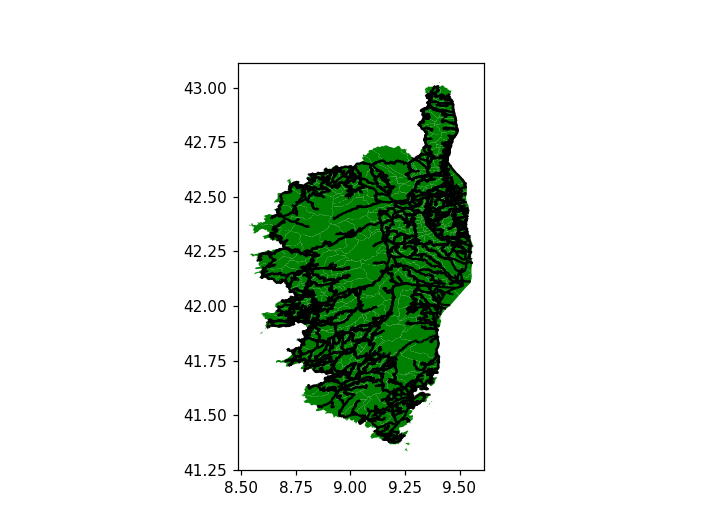

In [4]:
edges = gpd.read_file(gis_folder + r'osmdrive/edges/edges.shp')
nodes = gpd.read_file(gis_folder + r'osmdrive/nodes/nodes.shp')

stops = gpd.read_file(gis_folder + r'stops_corse.shp')
communes = gpd.read_file(gis_folder + r'communes_corse.shp')

edges.plot(ax=communes.plot(color='green'), color='black')
plt.savefig(r'../plot/edges.png')

In [5]:
commune_nearest_node = pd.read_csv(data_folder + 'commune_nearest_node.csv').astype(str)

In [6]:
stop_nearest_node = pd.read_csv(data_folder + 'stop_nearest_node.csv').astype(str)

In [7]:
stop_nearest_node.head(1)

stop  stop_node
0    0  255850481

In [8]:
commune_nearest_node.head(1)

commune commune_node
0   2A001    415904387

In [9]:
len(commune_nearest_node)

360

In [10]:
communes.head(1)

insee                                           geometry
0  2B047  POLYGON ((8.993128003604662 42.32553598698841,...

In [11]:
edges[['from', 'to']] = edges[['from', 'to']]
edges['length'] = edges['length'].astype(float)

<font color='#D22328'>
# Exercice: construction du graphe routier
</font>


* créer le graphe directionnel «dg»
* créer la liste des arêtes  [[from, to, length],[from, to, length]] à partir du DataFrame edges
* créer la liste des arêtes  [[to, from, length],[to, from, length]] à partir du DataFrame edges
* ajouter les arètes pondérées à «dg»
* afficher le chemin entre deux points au choix
* [bonus] visualiser le chemin sur la carte

# Calcul des distances nœud à nœud dans le graphe 
pour les nœuds les plus proches des gares

In [34]:
node_single_sources = dict()

for stop_node in tqdm(list(stop_nearest_node['stop_node'])):
    
    # pour chacun des nœuds associé à une gare
    # on calcule la distance vers tous les nœuds du réseau
    # on stocke cette valeur dans un dictionnaire: la clé est le nœud de départ
    lengths = nx.single_source_dijkstra_path_length(dg, stop_node)
    node_single_sources[stop_node] = lengths

100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 21.79it/s]


In [35]:
# node_single_source est un dictionnaire imbriqué
source = '1039032311'
target = '1202337494'
node_single_sources[source][target] # accès aux valeurs d'un dictionnaire

748.5017176940135

In [36]:
# on parcourt le dictionnaire imbriqué pour le transformer en liste de listes
node_node_graph_distance = []
for stop_node, lengths in node_single_sources.items():
    for node, length in lengths.items():
        node_node_graph_distance.append((stop_node, node, length))

In [37]:
node_node = pd.DataFrame(node_node_graph_distance, columns=['stop_node', 'commune_node', 'distance'])

In [38]:
node_node.head()

stop_node commune_node   distance
0  255850481    255850481   0.000000
1  255850481     21103145  27.562942
2  255850481    416980952  33.125070
3  255850481    423745219  53.789796
4  255850481    423745845  59.049511

In [39]:
node_node.to_csv(data_folder+'node_node_graph_distance.csv', index=False)

# Contrôle

In [40]:
merged = pd.merge(
    nodes, 
    node_node.groupby('commune_node')[['distance']].min(),
    left_on='osmid',
    right_index=True
)

<IPython.core.display.Javascript object>


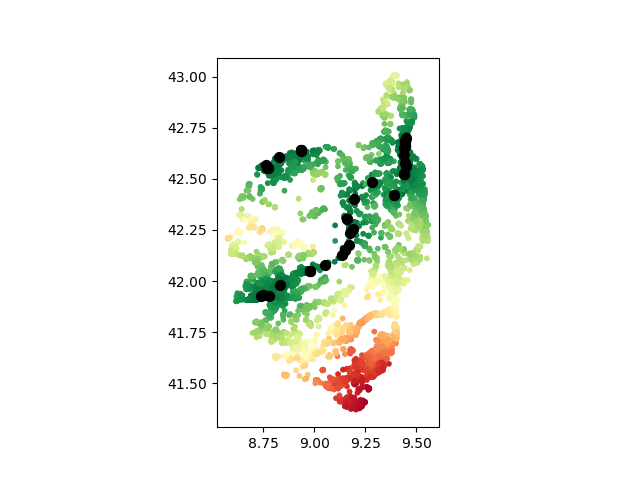

In [41]:

import matplotlib.pyplot as plt
stops.plot(
    ax= merged.plot(
        column='distance', 
        k=100, 
        cmap='RdYlGn_r', 
        markersize=10
    ),
    markersize=50,
    color='black'
)
plt.savefig(r'../plot/node_distance.png')

In [42]:
merged.to_file(gis_folder + 'accessibility_nodes.shp')